# TESTING HYPERPARAMETERS
# TRANSFORMER. 8 featerow - mag, x, y, depth, dist, distance, plate, days_diff. 
### num_layers=2, d_model=48, num_heads=4

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
SEED = 1337
tf.random.set_seed(SEED)
np.random.seed(SEED)

2024-01-12 18:11:48.950590: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 18:11:48.951074: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 18:11:48.952432: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 18:11:49.263991: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 18:11:52.435042: W tensorflow/compiler/

In [3]:
ds_train = tf.data.Dataset.load("../data/ds_train/")
ds_val = tf.data.Dataset.load("../data/ds_val/")
ds_test = tf.data.Dataset.load("../data/ds_test/")

2024-01-12 18:11:58.252535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 18:11:59.307578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 18:11:59.307842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 18:11:59.384600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 18:11:59.384880: I tensorflow/compile

In [4]:
ds_train.cardinality().numpy(), ds_val.cardinality().numpy(), ds_test.cardinality().numpy()

(3294436, 465661, 101326)

In [5]:
BATCH_SIZE = 1024
BLOCK_SIZE = 64

In [6]:
def fix_x_and_y(features, context, labels):
    return features, labels

In [7]:
ds_train = ds_train.map(fix_x_and_y)
ds_val = ds_val.map(fix_x_and_y)
ds_test = ds_test.map(fix_x_and_y)

In [8]:
for x, y in ds_train.batch(BATCH_SIZE).take(1):
    print(x[0].shape)
    print(x[1].shape)
    print(y.shape)

(64, 9)
(64, 9)
(1024, 1)


In [9]:
# ys = []
# for x, y in ds_train.batch(BATCH_SIZE):
#     ys.append(y.numpy())
# ys = np.concatenate(ys)
# np.bincount(tf.cast(ys, tf.int32).numpy().flatten())

In [10]:
#neg, pos = np.bincount(tf.cast(ys, tf.int32).numpy().flatten())
neg, pos = 3094591, 199845
total = neg + pos
total, pos, neg

(3294436, 199845, 3094591)

In [11]:
ds_train = ds_train.batch(BATCH_SIZE).shuffle(2000, seed=SEED, reshuffle_each_iteration=False).prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
class PositionalEmbedding(tf.keras.models.Model):
    def __init__(self, d_model):
        super().__init__(name="positional_embedding")
        self.dense = tf.keras.layers.Dense(d_model // 9 * 6, name="embed_continous")
        self.embed_dd = tf.keras.layers.Embedding(20, d_model // 9, name="embed_dd")
        self.embed_plate = tf.keras.layers.Embedding(64, d_model // 9, name="embed_plate")
        self.embed_magtype = tf.keras.layers.Embedding(20, d_model // 9, name="embed_magtype")
        self.conc = tf.keras.layers.Concatenate(name="concatenate")
        self.pos_encoding = tf.keras.layers.Embedding(64, d_model, name="pos_encoding")
        self.add = tf.keras.layers.Add(name="add")
    
    def build_graph(self):
        x = [tf.keras.Input(shape=(BLOCK_SIZE, 6), batch_size=None, name="input_continous"),
            tf.keras.Input(shape=(BLOCK_SIZE), batch_size=None, name="input_plate"),
            tf.keras.Input(shape=(BLOCK_SIZE), batch_size=None, name="input_dd"),
            tf.keras.Input(shape=(BLOCK_SIZE), batch_size=None, name="input_magtype"),
            tf.keras.Input(shape=(BLOCK_SIZE), batch_size=None, name="input_pos")]
        return tf.keras.Model(inputs=x, outputs=self.call(x))

    def call(self, x):
        cont, plate, dd, magtype, pos = x
        x1 = self.dense(cont)
        x2 = self.embed_dd(dd)
        x3 = self.embed_plate(plate)
        x4 = self.embed_magtype(magtype)
        x = self.conc([x1, x2, x3, x4])
        x_pos = self.pos_encoding(pos)
        x = self.add([x, x_pos])
        return x

In [13]:
model = PositionalEmbedding(99)

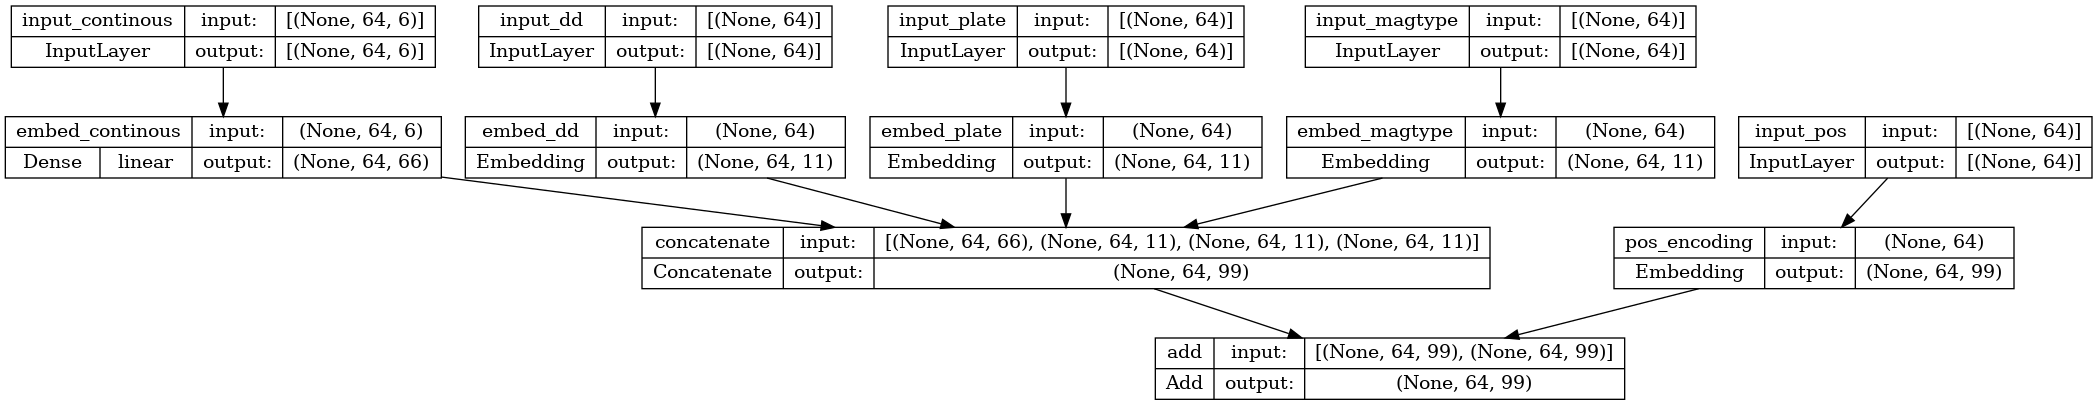

In [14]:
tf.keras.utils.plot_model(model.build_graph(), show_shapes=True, expand_nested=True, show_layer_activations=True)

In [15]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs, name="self_attention")
        self.layernorm = tf.keras.layers.LayerNormalization(name="layernorm")
        self.add = tf.keras.layers.Add(name="add")

In [16]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [17]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu', name="dense"),
            tf.keras.layers.Dense(d_model, name="dense_1"),
            tf.keras.layers.Dropout(dropout_rate, name="dropout_ff")
        ], name="feed_forward")
        self.add = tf.keras.layers.Add(name="add_ff")
        self.layer_norm = tf.keras.layers.LayerNormalization(name="layernorm_ff")

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [18]:
class DecoderBlock(tf.keras.models.Model):
    def __init__(self,
                d_model,
                num_heads,
                dff,
                name,
                dropout_rate=0.1):
        
        super(DecoderBlock, self).__init__(name=name)

        self.causal_self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def build_graph(self):
        x = tf.keras.Input(shape=(4, 72), batch_size=None, name="input")
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

    def call(self, x):
        #x = self.causal_self_attention(x=x)
        x_attn = self.causal_self_attention.mha(
            query=x,
            value=x,
            key=x)
        x = self.causal_self_attention.add([x, x_attn])
        x = self.causal_self_attention.layernorm(x)
        #x = self.ffn(x)
        x_ffn = self.ffn.seq(x)
        x = self.ffn.add([x, x_ffn])
        x = self.ffn.layer_norm(x)
        return x

In [19]:
model = DecoderBlock(d_model=72, num_heads=2, dff=99*4, name="decoder_block")

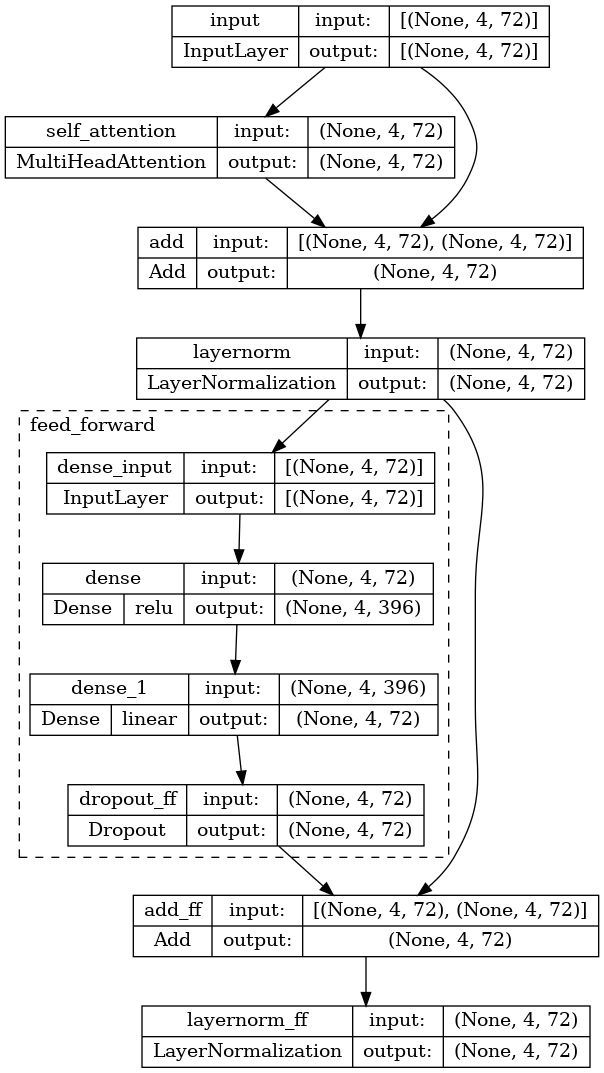

In [20]:
tf.keras.utils.plot_model(model.build_graph(), show_shapes=True, expand_nested=True, show_layer_activations=True)

In [116]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, dropout_rate=0.1):
        super(Decoder, self).__init__(name="decoder")
        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate, name="dropout")
        self.dec_blocks = [
            DecoderBlock(d_model=d_model, num_heads=num_heads,
                        dff=dff, name=f"dec_block{_}", dropout_rate=dropout_rate)
            for _ in range(num_layers)]

    def call(self, x):
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
        x = self.dropout(x)
        for block in self.dec_blocks:
            x = block(x)
        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [152]:
@tf.keras.utils.register_keras_serializable()
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads,
                dropout_rate=0.1):
        super().__init__()
        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                            num_heads=num_heads, dff=4*d_model,
                            dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid', name="classifier")

        self.add = tf.keras.layers.Add()
    
    def build_graph(self):
        x = [tf.keras.Input(shape=(BLOCK_SIZE, 6), batch_size=None, name="input_continous"),
            tf.keras.Input(shape=(BLOCK_SIZE), batch_size=None, name="input_plate"),
            tf.keras.Input(shape=(BLOCK_SIZE), batch_size=None, name="input_dd"),
            tf.keras.Input(shape=(BLOCK_SIZE), batch_size=None, name="input_magtype")]
        return tf.keras.Model(inputs=x, outputs=self.call(x))

    def call(self, inputs):
        #x = self.decoder(inputs)
        #x = self.decoder.pos_embedding(inputs)

        cont, plate, dd, magtype = inputs
        x1 = self.decoder.pos_embedding.dense(cont)
        x2 = self.decoder.pos_embedding.embed_dd(dd)
        x3 = self.decoder.pos_embedding.embed_plate(plate)
        x4 = self.decoder.pos_embedding.embed_magtype(magtype)
        x = self.decoder.pos_embedding.conc([x1, x2, x3, x4])
        x_pos = self.decoder.pos_embedding.pos_encoding(tf.range(x1.shape[1]))
        x = x + x_pos
        
        x = self.decoder.dropout(x)
        #x = self.decoder.dec_blocks[0](x)
        #x = self.decoder.dec_blocks[0].causal_self_attention(x=x)
        x_attn = self.decoder.dec_blocks[0].causal_self_attention.mha(query=x, value=x, key=x)
        x = self.decoder.dec_blocks[0].causal_self_attention.add([x, x_attn])
        x = self.decoder.dec_blocks[0].causal_self_attention.layernorm(x)
        x = self.decoder.dec_blocks[0].ffn(x)

        #x = self.decoder.dec_blocks[1](x)
        #x = self.decoder.dec_blocks[1].causal_self_attention(x=x)
        x_attn = self.decoder.dec_blocks[1].causal_self_attention.mha(query=x, value=x, key=x)
        x = self.decoder.dec_blocks[1].causal_self_attention.add([x, x_attn])
        x = self.decoder.dec_blocks[1].causal_self_attention.layernorm(x)
        x = self.decoder.dec_blocks[1].ffn(x)
        x = x[:, -1, :]
        logits = self.final_layer(x)
        return logits

In [153]:
model = Transformer(num_layers=2, d_model=99, num_heads=2)

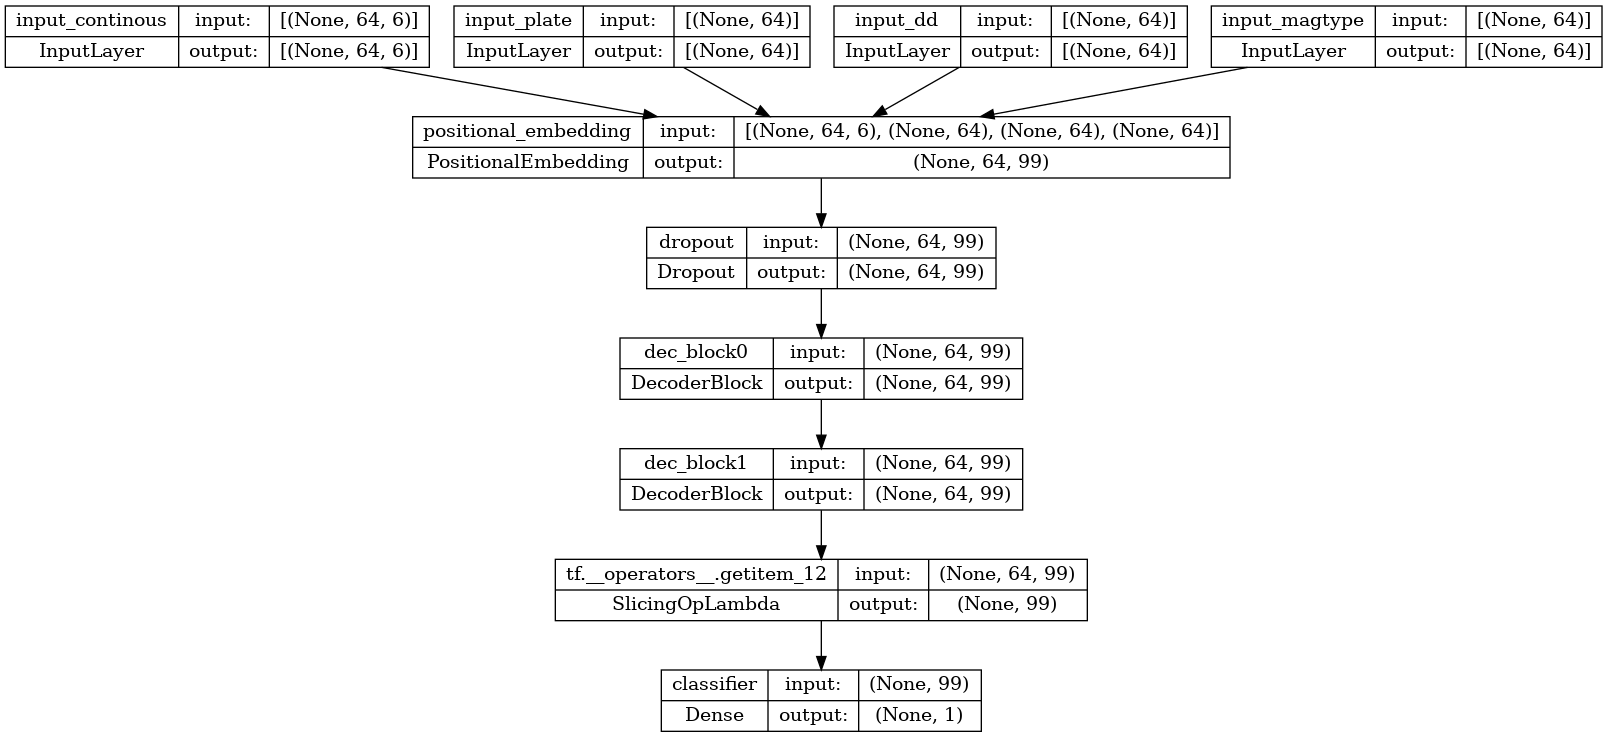

In [119]:
tf.keras.utils.plot_model(model.build_graph(), show_shapes=True, expand_nested=True)

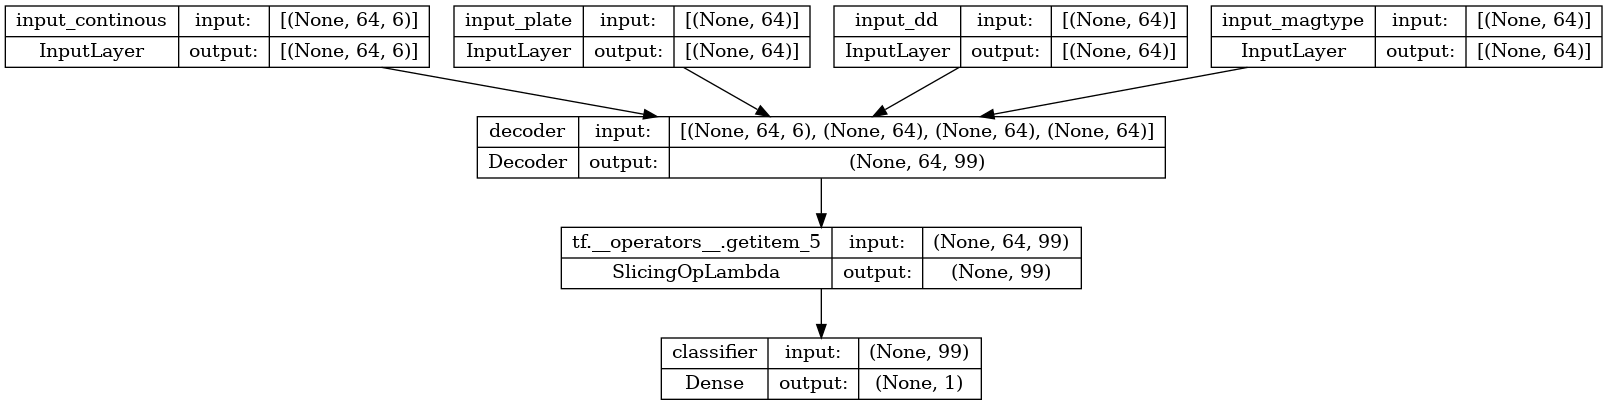

In [66]:
tf.keras.utils.plot_model(model.build_graph(), show_shapes=True, expand_nested=True)

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            optimizer='adam',
            metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [21]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
history = model.fit(ds_train, epochs=20, validation_data=ds_val, class_weight=class_weight)

Epoch 1/20


2024-01-06 06:07:07.206178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 133 of 2000
2024-01-06 06:07:27.225357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 385 of 2000
2024-01-06 06:07:39.319627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 441 of 2000
2024-01-06 06:07:57.190745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 679 of 2000
2024-01-06 06:09:05.079416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 902 of 2000
2024-01-06 06:09:17.184317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 2389s 661ms/step - loss: 0.4795 - accuracy: 0.8202 - recall: 0.7457 - precision: 0.2158 - val_loss: 0.5021 - val_accuracy: 0.7988 - val_recall: 0.6126 - val_precision: 0.1773
Epoch 2/20


2024-01-06 06:46:51.798831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 180 of 2000
2024-01-06 06:47:01.798701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 371 of 2000
2024-01-06 06:47:21.799216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 808 of 2000
2024-01-06 06:47:41.787975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1252 of 2000
2024-01-06 06:47:51.788823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1460 of 2000
2024-01-06 06:48:01.834334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take 

3218/3218 [==============================] - 2404s 714ms/step - loss: 0.4392 - accuracy: 0.8418 - recall: 0.7633 - precision: 0.2435 - val_loss: 0.4366 - val_accuracy: 0.8597 - val_recall: 0.4785 - val_precision: 0.2166
Epoch 3/20


2024-01-06 07:26:59.621458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 101 of 2000
2024-01-06 07:27:15.521509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 332 of 2000
2024-01-06 07:27:25.586769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 498 of 2000
2024-01-06 07:27:45.540435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 885 of 2000
2024-01-06 07:27:55.572663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1084 of 2000
2024-01-06 07:28:15.550565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a

3218/3218 [==============================] - 2404s 709ms/step - loss: 0.4283 - accuracy: 0.8448 - recall: 0.7680 - precision: 0.2482 - val_loss: 0.5110 - val_accuracy: 0.8458 - val_recall: 0.5925 - val_precision: 0.2226
Epoch 4/20


2024-01-06 08:06:59.805603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 135 of 2000
2024-01-06 08:07:09.833967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 279 of 2000
2024-01-06 08:07:29.809271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 566 of 2000
2024-01-06 08:07:49.813592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 855 of 2000
2024-01-06 08:08:10.448229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1096 of 2000
2024-01-06 08:08:29.814460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a

3218/3218 [==============================] - 2452s 714ms/step - loss: 0.4218 - accuracy: 0.8461 - recall: 0.7745 - precision: 0.2510 - val_loss: 0.4361 - val_accuracy: 0.8519 - val_recall: 0.4970 - val_precision: 0.2095
Epoch 5/20


2024-01-06 08:47:51.937655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 139 of 2000
2024-01-06 08:48:14.483518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 172 of 2000
2024-01-06 08:48:31.949909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 370 of 2000
2024-01-06 08:48:51.938710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 662 of 2000
2024-01-06 08:49:01.966681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 795 of 2000
2024-01-06 08:49:21.987342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 2444s 707ms/step - loss: 0.4123 - accuracy: 0.8465 - recall: 0.7857 - precision: 0.2533 - val_loss: 0.4595 - val_accuracy: 0.8331 - val_recall: 0.5503 - val_precision: 0.1980
Epoch 6/20


2024-01-06 09:28:35.855518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 124 of 2000
2024-01-06 09:28:55.801945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 382 of 2000
2024-01-06 09:29:05.848430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 525 of 2000
2024-01-06 09:29:25.789459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 803 of 2000
2024-01-06 09:29:45.780833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 1062 of 2000
2024-01-06 09:29:55.797818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a

3218/3218 [==============================] - 2481s 719ms/step - loss: 0.4039 - accuracy: 0.8469 - recall: 0.7926 - precision: 0.2549 - val_loss: 0.4182 - val_accuracy: 0.8411 - val_recall: 0.5496 - val_precision: 0.2073
Epoch 7/20


2024-01-06 10:09:56.443289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 120 of 2000
2024-01-06 10:10:16.445024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 365 of 2000
2024-01-06 10:10:26.507376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 470 of 2000
2024-01-06 10:10:36.511274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 592 of 2000
2024-01-06 10:10:56.435108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 834 of 2000
2024-01-06 10:11:16.461953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 2442s 707ms/step - loss: 0.4035 - accuracy: 0.8448 - recall: 0.7942 - precision: 0.2524 - val_loss: 0.4727 - val_accuracy: 0.7983 - val_recall: 0.5831 - val_precision: 0.1713
Epoch 8/20


2024-01-06 10:50:39.206437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 106 of 2000
2024-01-06 10:50:59.139446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 342 of 2000
2024-01-06 10:51:19.110550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 602 of 2000
2024-01-06 10:51:29.122999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 737 of 2000
2024-01-06 10:51:39.140259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 865 of 2000
2024-01-06 10:51:50.552436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 2461s 711ms/step - loss: 0.3959 - accuracy: 0.8460 - recall: 0.8020 - precision: 0.2552 - val_loss: 0.4810 - val_accuracy: 0.7892 - val_recall: 0.6650 - val_precision: 0.1790
Epoch 9/20


2024-01-06 11:31:39.881410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 100 of 2000
2024-01-06 11:31:49.916964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 223 of 2000
2024-01-06 11:32:00.003574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 317 of 2000
2024-01-06 11:32:19.953815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 560 of 2000
2024-01-06 11:32:39.906234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 787 of 2000
2024-01-06 11:32:59.890285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 2455s 709ms/step - loss: 0.3928 - accuracy: 0.8432 - recall: 0.8077 - precision: 0.2523 - val_loss: 0.4515 - val_accuracy: 0.8292 - val_recall: 0.7551 - val_precision: 0.2321
Epoch 10/20


2024-01-06 12:12:35.397174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 107 of 2000
2024-01-06 12:12:45.475528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 215 of 2000
2024-01-06 12:13:05.409410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 431 of 2000
2024-01-06 12:13:25.309336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 642 of 2000
2024-01-06 12:13:35.311451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 751 of 2000
2024-01-06 12:13:45.348411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 2470s 710ms/step - loss: 0.3829 - accuracy: 0.8441 - recall: 0.8199 - precision: 0.2555 - val_loss: 0.4220 - val_accuracy: 0.8430 - val_recall: 0.5724 - val_precision: 0.2147
Epoch 11/20


2024-01-06 12:53:45.260835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 95 of 2000
2024-01-06 12:53:55.284156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 180 of 2000
2024-01-06 12:54:15.183892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 378 of 2000
2024-01-06 12:54:25.228594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 470 of 2000
2024-01-06 12:54:35.250147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 567 of 2000
2024-01-06 12:54:45.259653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 2516s 722ms/step - loss: 0.3770 - accuracy: 0.8439 - recall: 0.8260 - precision: 0.2561 - val_loss: 0.4267 - val_accuracy: 0.8399 - val_recall: 0.7035 - val_precision: 0.2362
Epoch 12/20


2024-01-06 13:35:41.521242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 89 of 2000
2024-01-06 13:36:01.442407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 296 of 2000
2024-01-06 13:36:21.460630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 484 of 2000
2024-01-06 13:36:41.440993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 671 of 2000
2024-01-06 13:37:01.432139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 899 of 2000
2024-01-06 13:37:21.438557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 2465s 708ms/step - loss: 0.3736 - accuracy: 0.8469 - recall: 0.8264 - precision: 0.2601 - val_loss: 0.4566 - val_accuracy: 0.8126 - val_recall: 0.7722 - val_precision: 0.2173
Epoch 13/20


2024-01-06 14:16:46.160180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 104 of 2000
2024-01-06 14:16:56.224275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 211 of 2000
2024-01-06 14:17:06.229839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 315 of 2000
2024-01-06 14:17:16.245954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 411 of 2000
2024-01-06 14:17:36.162560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 625 of 2000
2024-01-06 14:17:56.207809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a 

3218/3218 [==============================] - 2464s 707ms/step - loss: 0.3654 - accuracy: 0.8479 - recall: 0.8323 - precision: 0.2624 - val_loss: 0.3980 - val_accuracy: 0.8405 - val_recall: 0.5614 - val_precision: 0.2092
Epoch 14/20


2024-01-06 14:57:50.425598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 96 of 2000
2024-01-06 14:58:00.412445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 187 of 2000
2024-01-06 14:58:20.406623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 375 of 2000
2024-01-06 14:58:40.373421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 570 of 2000
2024-01-06 14:59:00.442192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 763 of 2000
2024-01-06 14:59:20.429246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 1343s 356ms/step - loss: 0.3594 - accuracy: 0.8504 - recall: 0.8375 - precision: 0.2666 - val_loss: 0.3953 - val_accuracy: 0.8471 - val_recall: 0.5957 - val_precision: 0.2250
Epoch 15/20


2024-01-06 15:20:13.398779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 86 of 2000
2024-01-06 15:20:23.403341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 171 of 2000
2024-01-06 15:20:33.531003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 251 of 2000
2024-01-06 15:20:53.469622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 440 of 2000
2024-01-06 15:21:03.360373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 530 of 2000
2024-01-06 15:21:13.410679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 1016s 250ms/step - loss: 0.3535 - accuracy: 0.8515 - recall: 0.8424 - precision: 0.2689 - val_loss: 0.3936 - val_accuracy: 0.8460 - val_recall: 0.7079 - val_precision: 0.2450
Epoch 16/20


2024-01-06 15:37:09.795037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 91 of 2000
2024-01-06 15:37:19.832026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 176 of 2000
2024-01-06 15:37:39.843806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 364 of 2000
2024-01-06 15:37:59.798649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 553 of 2000
2024-01-06 15:38:09.811151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 656 of 2000
2024-01-06 15:38:19.833898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 1003s 250ms/step - loss: 0.3459 - accuracy: 0.8548 - recall: 0.8472 - precision: 0.2744 - val_loss: 0.3901 - val_accuracy: 0.8467 - val_recall: 0.6520 - val_precision: 0.2357
Epoch 17/20


2024-01-06 15:53:52.568441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 84 of 2000
2024-01-06 15:54:12.570047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 280 of 2000
2024-01-06 15:54:22.638360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 353 of 2000
2024-01-06 15:54:42.529181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 529 of 2000
2024-01-06 15:55:02.612941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 717 of 2000
2024-01-06 15:55:22.545791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 984s 241ms/step - loss: 0.3428 - accuracy: 0.8573 - recall: 0.8460 - precision: 0.2779 - val_loss: 0.3880 - val_accuracy: 0.8418 - val_recall: 0.7031 - val_precision: 0.2387
Epoch 18/20


2024-01-06 16:10:16.523342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 87 of 2000
2024-01-06 16:10:36.416237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 271 of 2000
2024-01-06 16:10:46.491321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 352 of 2000
2024-01-06 16:11:06.447853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 538 of 2000
2024-01-06 16:11:16.470667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 633 of 2000
2024-01-06 16:11:26.492474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 993s 245ms/step - loss: 0.3401 - accuracy: 0.8558 - recall: 0.8504 - precision: 0.2763 - val_loss: 0.4564 - val_accuracy: 0.7797 - val_recall: 0.7173 - val_precision: 0.1806
Epoch 19/20


2024-01-06 16:26:49.511112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 75 of 2000
2024-01-06 16:26:59.584152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 162 of 2000
2024-01-06 16:27:19.427474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 350 of 2000
2024-01-06 16:27:29.456237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 436 of 2000
2024-01-06 16:27:39.463411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 519 of 2000
2024-01-06 16:27:49.525308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 978s 238ms/step - loss: 0.3335 - accuracy: 0.8562 - recall: 0.8555 - precision: 0.2776 - val_loss: 0.4138 - val_accuracy: 0.8209 - val_recall: 0.6031 - val_precision: 0.1956
Epoch 20/20


2024-01-06 16:43:08.004072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 83 of 2000
2024-01-06 16:43:27.966301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 257 of 2000
2024-01-06 16:43:48.002165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 430 of 2000
2024-01-06 16:44:08.028256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 609 of 2000
2024-01-06 16:44:27.916638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 788 of 2000
2024-01-06 16:44:37.926609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a w

3218/3218 [==============================] - 974s 235ms/step - loss: 0.3292 - accuracy: 0.8589 - recall: 0.8576 - precision: 0.2820 - val_loss: 0.4388 - val_accuracy: 0.8096 - val_recall: 0.7154 - val_precision: 0.2051


In [22]:
model.evaluate(ds_test)

99/99 [==============================] - 10s 98ms/step - loss: 0.4186 - accuracy: 0.8009 - recall: 0.8113 - precision: 0.0858


[0.4186244308948517,
 0.8009099364280701,
 0.8112959861755371,
 0.08580689877271652]

In [23]:
model.save("../models/model_v4_cw.keras")

In [24]:
# save history
history = pd.DataFrame.from_dict(history.history)
history.to_csv("../models/history_model_v4_cw.csv", index=False)